Magnetic Inversion - Simple vs Tikhonov Regularization
=

**Objective**

Invert mag data on a TreeMesh using Simple and Tikhonov


In [1]:
# Load the various libraries
from SimPEG import Mesh, Directives, Maps, InvProblem, Optimization, DataMisfit, Inversion, Utils, Regularization
import SimPEG.PF as PF
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from SimPEG.Utils import speye

Data
==

First we need to load some mag data.

In [2]:
# Load some data in x,y,z,data(nT)
# dataMat = np.loadtxt('.\Synthetic\Obs_loc_TMI.obs')
# xyzLoc = dataMat[:,:3]
# data = dataMat[:,3]

# The data was simulated with a simple vertical inducing field. 
# This only matters for the data projection.
H0 = [50000, 90 , 0] # Strenght (nT), Inc (deg), Dec (deg)

# We can create a Topo
xr = np.linspace(-100., 100., 5)
yr = np.linspace(-100., 100., 5)
X, Y = np.meshgrid(xr, yr)
Z = np.zeros(X.size)+5. # Let just put the observation flat

topo = np.c_[Utils.mkvc(X.T), Utils.mkvc(Y.T), Utils.mkvc(Z.T*0)]


**Mesh**
=====
Now we need a mesh to invert physical properties on. 
I provided a mesh in the same folder, but generally you won't have one.
It is a tradeoff between having a very large problem to solve (too small cells) versus resolution (too coarse). Usually recommended to have 1 or 2 cells between each survey lines.

We created a small utility to generate a mesh based on the core cell dimension and padding distance. Use at your own risk ;)

In [3]:
from scipy.interpolate import NearestNDInterpolator
from SimPEG.Utils.matutils import mkvc
def refineTree(mesh, xyz, finalize=False, dtype="point", nCpad=[1, 1, 1]):

    maxLevel = int(np.log2(mesh.hx.shape[0]))

    if dtype == "point":

        mesh.insert_cells(xyz, np.ones(xyz.shape[0])*maxLevel, finalize=False)

        stencil = np.r_[
                np.ones(nCpad[0]),
                np.ones(nCpad[1])*2,
                np.ones(nCpad[2])*3
            ]

        # Reflect in the opposite direction
        vec = np.r_[stencil[::-1], 1, stencil]
        vecX, vecY, vecZ = np.meshgrid(vec, vec, vec)
        gridLevel = np.maximum(np.maximum(np.abs(vecX),
                               np.abs(vecY)), np.abs(vecZ))
        print(gridLevel.shape)
        gridLevel = np.kron(np.ones(xyz.shape[0]), mkvc(gridLevel))
        print(np.ones((xyz.shape[0], 1)).shape, gridLevel.shape)
        # Grid the coordinates
        vec = np.r_[-np.cumsum(stencil)[::-1], 0, np.cumsum(stencil)]
        vecX, vecY, vecZ = np.meshgrid(vec, vec, vec)
        offset = np.c_[
            mkvc(np.sign(vecX)*np.abs(vecX) * mesh.hx.min()),
            mkvc(np.sign(vecY)*np.abs(vecY) * mesh.hy.min()),
            mkvc(np.sign(vecZ)*np.abs(vecZ) * mesh.hz.min())
        ]

        # Replicate the point locations in each offseted grid points
        newLoc = (
            np.kron(xyz, np.ones((offset.shape[0], 1))) +
            np.kron(np.ones((xyz.shape[0], 1)), offset)
        )
        
        for ii in range(3):
            ind = gridLevel==ii
            print(ind.shape, newLoc.shape, gridLevel.shape)
            mesh.insert_cells(
                newLoc[ind,:], maxLevel-mkvc(gridLevel[ind])+1, finalize=False
            )

        if finalize:
            mesh.finalize()
            
    elif dtype == 'surface':

        # Get extent of points
        limx = np.r_[xyz[:, 0].max(), xyz[:, 0].min()]
        limy = np.r_[xyz[:, 1].max(), xyz[:, 1].min()]

        F = NearestNDInterpolator(xyz[:, :2], xyz[:, 2])
        zOffset = 0
        # Cycle through the first 3 octree levels
        for ii in range(3):

            dx = mesh.hx.min()*2**ii

            # Horizontal offset
            xyOff = dx * 2

            nCx = int(limx[0]-limx[1] + 2 * xyOff) / dx
            nCy = int(limy[0]-limy[1] + 2 * xyOff) / dx

            # Create a grid at the octree level in xy
            CCx, CCy = np.meshgrid(
                np.linspace(limx[1]-xyOff, limx[0]+xyOff, nCx),
                np.linspace(limy[1]-xyOff, limy[0]+xyOff, nCy)
            )

            z = F(mkvc(CCx), mkvc(CCy))

            for level in range(int(nCpad[ii])):

                mesh.insert_cells(
                    np.c_[mkvc(CCx), mkvc(CCy), z-zOffset], np.ones_like(z)*maxLevel-ii,
                    finalize=False
                )

                zOffset += dx

        if finalize:
            mesh.finalize()

    else:
        NotImplementedError("Only dtype='points' has been implemented")

    return mesh

In [4]:
# Create a MAGsurvey
xyzLoc = np.c_[Utils.mkvc(X.T), Utils.mkvc(Y.T), Utils.mkvc(Z.T)]
rxLoc = PF.BaseMag.RxObs(xyzLoc)
srcField = PF.BaseMag.SrcField([rxLoc], param=H0)
survey = PF.BaseMag.LinearSurvey(srcField) 



# I want 10 m cells in x, y and z covering our survey
h = np.r_[5., 5., 5.]

# Also need to paddout far enough in case there is a regional field
# Here I am sending distances N, S, E, W, above and below all at once
# Let's say 200 m padding
padDist = np.ones((3,2))*200.

mesh = Utils.modelutils.meshBuilder(topo, h, padDist,
                   meshGlobal=None,
                   expFact=1.3,
                   meshType='TREE',
                   verticalAlignment='top')

# mesh = refineTree(mesh, topo, finalize=False, dtype="surface", nCpad=[0, 1, 0])

mesh = Utils.modelutils.refineTree(mesh, xyzLoc, finalize=True, dtype="point", nCpad=[1, 1, 0])

# First we need to discretize the topo onto the mesh
# This function will assign 0:air, 1:ground
actv = np.ones(mesh.nC, dtype='bool') #Utils.modelutils.surface2ind_topo(mesh, topo+1, gridLoc='CC', method='nearest')
nC = int(np.sum(actv))

# Creat reduced identity map
idenMap = Maps.IdentityMap(nP=nC)

# Create the forward model operator
prob = PF.Magnetics.MagneticIntegral(mesh, chiMap=idenMap,
                                     actInd=actv,
                                    parallelized=True)
# Pair the survey and problem
survey.pair(prob)



# And save a copy on disk for later use
# mesh.writeUBC("MeshOctree.msh", models:{'TensorTest.msh':actv})

In [5]:
# # We can plot it to see
# ax = plt.subplot()
# mesh.plotSlice(actv, normal='Z', ax=ax)
# ax.set_xlim(-100,100)
# ax.set_ylim(-100,100)
# plt.show()

Begin forward: M=H0, Rx type= tmi


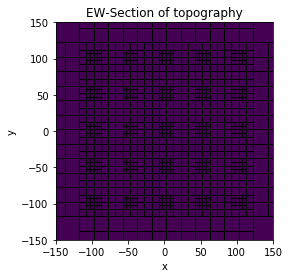

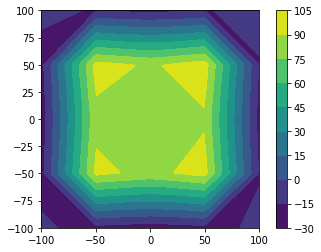

In [6]:
# Add a block 
ind = Utils.ModelBuilder.getIndicesBlock(np.r_[-75,-75,-50], np.r_[75,75,-10], mesh.gridCC)
model = np.zeros(mesh.nC)
model[ind] = 0.01

actvMap = Maps.InjectActiveCells(mesh, actv, 0)
mesh.writeUBC('OctreeMesh.msh', models={"Model.sus":model})

dobs = prob.fields(model[actv])
survey.dobs = dobs
survey.std = np.ones_like(dobs) * np.abs(dobs).min()


# We can check how the discretized topography looks
plt.figure()
ax = plt.subplot()
mesh.plotSlice(model, ax = ax, normal = 'Z', ind=-1, grid=True)
ax.set_title('EW-Section of topography')
ax.set_xlim(-150,150)
ax.set_ylim(-150,150)
ax.set_xlabel('x');ax.set_ylabel('y')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# Looking good
# We can plot the data, looks like this
# We can now generate data
im = Utils.PlotUtils.plot2Ddata(survey.srcField.rxList[0].locs, survey.dobs)
plt.colorbar(im[0])


Once we have our problem, we can use the inversion tools in SimPEG to run our inversion:

In [7]:
# Create sensitivity weights from our linear forward operator
rxLoc = survey.srcField.rxList[0].locs
wr = np.zeros(prob.G.shape[1])
for ii in range(survey.nD):
    wr += (prob.G[ii, :]/survey.std[ii])**2.

# wr = (wr/np.max(wr))
wr = wr**0.5

# Create a regularization
reg = Regularization.Sparse(mesh, indActive=actv, mapping=idenMap)
# reg.alpha_s=1e-12
reg.cell_weights = wr#driver.cell_weights*mesh.vol**0.5

reg.mref = np.zeros(nC)
# Data misfit function
dmis = DataMisfit.l2_DataMisfit(survey)
dmis.W = 1./survey.std

# Add directives to the inversion
opt = Optimization.ProjectedGNCG(maxIter=20, lower=0., upper=10.,
                                 maxIterLS=20, maxIterCG=10, tolCG=1e-4, tolG=1e-4, eps=1e-6)
invProb = InvProblem.BaseInvProblem(dmis, reg, opt)
betaest = Directives.BetaEstimate_ByEig()

# Here is where the norms are applied
# Use pick a treshold parameter empirically based on the distribution of
#  model parameters
IRLS = Directives.Update_IRLS(f_min_change=1e-3, minGNiter=1, maxIRLSiter=10, betaSearch=False)
update_Jacobi = Directives.UpdatePreconditioner()

# saveModel = Directives.SaveUBCModelEveryIteration(mapping=actvMap)
# saveModel.fileName = work_dir + out_dir + 'ModelSus'

inv = Inversion.BaseInversion(invProb,
                              directiveList=[betaest, IRLS, update_Jacobi])

# Run the inversion
m0 = np.ones(nC)  * 1e-4# Starting model
prob.model = m0
mrecSimple = inv.run(m0)

NotImplementedError: The out parameter is not fully supported. Received type ndarray, expected Dask Array

In [ ]:
# Et voila, now we can just slice it by changing the ind=#
limx = [-200,200]
plotMap = Maps.InjectActiveCells(mesh, actv, np.nan)
plt.figure()
ax = plt.subplot()
# im = mesh.plotSlice(plotMap*mrec, ax = ax, normal = 'Y')
im = mesh.plotSlice(plotMap*mrecSimple, normal='Z', ax=ax, ind=-6, clim=[0, mrecSimple.max()])
ax.set_xlim(limx)
ax.set_ylim(limx)
plt.colorbar(im[0])
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

Repeat with Tikhonov
==================

Set the $\alpha_s$ = $\frac{1}{dx^2}$, use sensitivity weighting again but scaled by volume since already in the regularization.

In [ ]:
# Create sensitivity weights from our linear forward operator
rxLoc = survey.srcField.rxList[0].locs
wr = np.zeros(prob.G.shape[1])
for ii in range(survey.nD):
    wr += (prob.G[ii, :]/survey.std[ii])**2.

# wr = (wr/np.max(wr))
wr = wr**0.5 / mesh.vol[actv]

# Create a regularization
# reg = Regularization.Sparse(mesh, indActive=actv, mapping=idenMap)

regTikh = Regularization.Tikhonov(mesh, mapping=idenMap, indActive=actv)
# reg.regmesh._cellDiffxStencil = regTikh.regmesh.cellDiffx
# reg.regmesh._cellDiffyStencil = regTikh.regmesh.cellDiffy
# reg.regmesh._cellDiffzStencil = regTikh.regmesh.cellDiffz
regTikh.cell_weights = wr#driver.cell_weights*mesh.vol**0.5

regTikh.mref = np.zeros(nC)
regTikh.alpha_s = 1./h[0]**2.

# Data misfit function
dmis = DataMisfit.l2_DataMisfit(survey)
dmis.W = 1./survey.std

# Add directives to the inversion
opt = Optimization.ProjectedGNCG(maxIter=20, lower=0., upper=10.,
                                 maxIterLS=20, maxIterCG=10, tolCG=1e-4, tolG=1e-4, eps=1e-6)
invProb = InvProblem.BaseInvProblem(dmis, regTikh, opt)
betaest = Directives.BetaEstimate_ByEig()

# Here is where the norms are applied
# Use pick a treshold parameter empirically based on the distribution of
#  model parameters
IRLS = Directives.Update_IRLS(f_min_change=1e-3, minGNiter=1, maxIRLSiter=10)
update_Jacobi = Directives.UpdatePreconditioner()
cooling = Directives.BetaSchedule(coolingRate=1)
target = Directives.TargetMisfit()
# saveModel = Directives.SaveUBCModelEveryIteration(mapping=actvMap)
# saveModel.fileName = work_dir + out_dir + 'ModelSus'

inv = Inversion.BaseInversion(invProb,
                              directiveList=[betaest,cooling, target, update_Jacobi])

# Run the inversion
m0 = np.ones(nC)  * 1e-4# Starting model
prob.model = m0
mrec = inv.run(m0)

In [ ]:
# Et voila, now we can just slice it by changing the ind=#
normal = 'Z'
ind = -7
limx = [-200,200]
limy = [-200,200]
import ipywidgets as widgets
plotMap = Maps.InjectActiveCells(mesh, actv, np.nan)
# normal = 'Y'
# ind = None
def plotSection():
    
    def plotIt(ind):
    
        plt.figure(figsize=(15,6))
        ax = plt.subplot(1,2,1)
        # im = mesh.plotSlice(plotMap*mrec, ax = ax, normal = 'Y')
        im = mesh.plotSlice(plotMap*mrec, normal=normal, ax=ax, ind=ind, clim=[0, mrec.max()])
        ax.set_xlim(limx)
        ax.set_ylim(limy)
        plt.colorbar(im[0])
        ax.set_title("Tikhonov")
        plt.gca().set_aspect('equal', adjustable='box')

        ax = plt.subplot(1,2,2)
        # im = mesh.plotSlice(plotMap*mrec, ax = ax, normal = 'Y')
        im = mesh.plotSlice(plotMap*mrecSimple, normal=normal, ax=ax, ind=ind, clim=[0, mrec.max()])
        ax.set_xlim(limx)
        ax.set_ylim(limy)
        plt.colorbar(im[0])
        plt.gca().set_aspect('equal', adjustable='box')
#         ax.set_title("Simple")
        plt.show()
        
    out = widgets.interactive(
        plotIt,ind = widgets.IntSlider(
                min=-200, max=0, step=1, value=-6,
                description='Slice from top', continuous_update=False
                )
    )
    return out

display(plotSection())



Hopefully you now have an idea of how to create a Problem class in SimPEG, and how this can be used with the other tools available.